In [1]:
import pickle
import sys

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm.auto import tqdm
tqdm.pandas()

# Import from the functions.py file
from functions.functions import (prep_variant_dataframe,
                                 prep_phenotype_dataframe,
                                 gather_stats,
                                 calculate_frequencies,
                                 split_sift_polyphen_class,
                                 count_samples_with_variants,
                                 do_burden_test)

# use seaborn plot styles
sns.set()

# increase max columns so we can see everything.
# Jupyter is nice in that it puts the table into a scrolling window
pd.set_option('display.max_columns', None)

C:\Users\ben\anaconda3\envs\mat-effect-genes\lib\site-packages\tqdm\std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Data loading and preparation

Load the full variant data from the Iridis processing steps (e.g. merging and VEP annotating all variants, splitting out to individual samples). Then do some initial filtering to remove the variants we are always going to want to remove - not present in a mother, duplicates from the same mother (from repeat testing with different children), uncertain genotypes, non-coding low-impact changes, not in samples passing PCA, and not classed as likely pathogenic by both SIFT and PolyPhen.

Stats are gathered on the number of variants removed at each step (for flow-chart generation), so that they can be plotted to show the details of the filtering (e.g. in a flowchart)

If the tsv has already been processed, it should be saved to a pickle - this saves re-processing the entire file, and saves a lot of time. However it does still take quite a while to load!

The data is filtered as follows:

1. Remove duplicates (where the variant ID and the maternal ID are the same). These are caused by the same mother being present more than once because they have multiple affected children - this causes duplication in the previous trio processing step
2. Remove uncertain genotypes. Where a variant position (which is detected in another sample) cannot be called at all (e.g. no coverage) it is given an uncertain genotype ./.. These variants should be removed as it is not known if they are present or absent in that sample
3. Remove variants which are not present in mothers. Due to the initial project aims and the method of sample loading, variants for all members of a trio were loaded. As the aim now is to only look at maternal variants, any non-maternal variants can be dropped.
4. Remove variants with a VEP IMPACT annotation of "LOW" or "MODIFIER". These are largely non-coding variants which are unlikely to be pathogenic and therefore unsuitable for burden testing.
5. Remove PCA outlier samples. Burden testing ideally requires a homogenous population, so remove the samples which did not cluster closely with the target European background by PCA.
6. **OPTIONAL:** Remove variants which aren't classed as likely pathogenic by both SIFT and Polyphen.

In [2]:
# Set the optional SIFT & PolyPhen filter
SIFT_FILTER = False

In [3]:
# Processing the main variant file is very slow and requires a lot of RAM
# so if the final output is stored in Processed_data just load that instead
try:
    # pickle.load is faster than pd.read_pickle (1m39 vs 2m2 for the big file)
    dataframe = pickle.load(open('Processed_data/TEMP.variants_processed.pickle', 'rb'))
    stats = pickle.load(open('Processed_data/TEMP.filtering_stats.pickle', 'rb'))    
except FileNotFoundError:
    # Load the data from the TSV file
    # TODO: Can this function be updated to support the compressed file and save space?
    dataframe = prep_variant_dataframe('Data/unfiltered_variants_v2.tsv', nrows_to_load=None)
    
    # Record the initial variant count before any processing
    stats = gather_stats(dataframe, "raw")
    
    # remove duplicate samples (i.e. where a maternal sample is included from multiple probands)
    dataframe = dataframe.drop_duplicates(subset=['MAT_ID', 'POS'], keep='first')
    stats = stats.append(gather_stats(dataframe, "deduplicated"))
    
    # Remove uncertain genotype
    # NOTE: During file loading the genotype has been converted to an allele count (e.g 0, 1, or 2)
    #       and uncertain genotypes (./.) have been set to -1
    dataframe = dataframe[dataframe['MAT_GT'] != -1]
    stats = stats.append(gather_stats(dataframe, "remove_mat_uncertain"), sort=False)
    
    # Remove variants which are not carried by the mother of a trio
    dataframe = dataframe[dataframe['MAT_GT'] != 0]
    stats = stats.append(gather_stats(dataframe, "present_in_mothers"), sort=False)
    
    # Remove the lOW and MODIFIER variants (by VEP predicted impact)
    dataframe = dataframe[dataframe['IMPACT'] != 'MODIFIER']
    stats = stats.append(gather_stats(dataframe, "no_modifiers"), sort=False) 
    dataframe = dataframe[dataframe['IMPACT'] != 'LOW']
    stats = stats.append(gather_stats(dataframe, "no_low_impact"), sort=False)
    
    # Get variants in PCA-passing samples only
    passing_samples =  pd.read_csv("Data/PCA_passing_samples.txt")
    # Drop variants where the MAT_ID isn't in the passing samples list
    # i.e. the variant is present, but in a mother who didn't pass PCA
    dataframe = dataframe[dataframe.MAT_ID.isin(passing_samples.MAT_ID)]
    stats = stats.append(gather_stats(dataframe, "PCA_passing"), sort=False)
    
    # OPTIONAL: Filter by Sift and Polyphen
    if SIFT_FILTER:
        # Normalise the classifications first
        dataframe['SIFT_class'] = dataframe.SIFT.apply(split_sift_polyphen_class)
        dataframe['Polyphen_class'] = dataframe.Polyphen.apply(split_sift_polyphen_class)
        # And keep only those which are both agreed on deleterious
        dataframe = dataframe[( dataframe.SIFT_class == "Deleterious" ) & ( dataframe.Polyphen_class == "Deleterious")]
        stats = stats.append(gather_stats(dataframe, "SIFT_Polyphen"), sort=False)

    # Save to temp pickles
    dataframe.to_pickle('Processed_data/TEMP.variants_processed.pickle')
    stats.to_pickle('Processed_data/TEMP.filtering_stats.pickle')

Plot a brief summary of the annotations, showing the distribution of scores in the (now filtered) dataset.

In [4]:
# This is kept here rather than in the functions.py file so that the exact setttings can be tweaked easily if needed.
def plot_summary(df):
    """Plot histograms for the key pathogenicity indicators"""
    f, ax = plt.subplots(2, 2, figsize=(15,15))

    f.suptitle("TEST", fontsize=18)
    
    # distplot is a lot quicker than histplot!
    sns.histplot(df.GnomAD_AF, bins=50, kde=False, ax=ax[0,0])
    missing = df.GnomAD_AF.isna().sum()
    print(f"Variants without GnomAD AF: {missing}/{df.shape[0]}", file=sys.stderr)

    # CADD
    sns.histplot(df.CADD_PHRED, bins=50, kde=False, ax=ax[0,1])
    # Count the null/missing values
    missing = df.CADD_PHRED.isna().sum()
    print(f"Variants without CADD score: {missing}/{df.shape[0]}", file=sys.stderr)

    # REVEL
    sns.histplot(df.REVEL, bins=50, kde=False, ax=ax[1,0])
    missing = df.REVEL.isna().sum()
    print(f"Variants without REVEL score: {missing}/{df.shape[0]}", file=sys.stderr)

    # CADD x REVEL
    sns.histplot(df, x="CADD_PHRED", y="REVEL", bins=30, cbar=False, ax=ax[1,1])
    
    # Summarise the variants and genes remaining
    print(f"Unique variants remaining: {df.ID.nunique()}", file=sys.stderr)
    print(f"In {df.GENE.nunique()} genes", file=sys.stderr)

Variants without GnomAD AF: 168635/12035879
Variants without CADD score: 63368/12035879
Variants without REVEL score: 1561894/12035879
Unique variants remaining: 167108
In 18615 genes


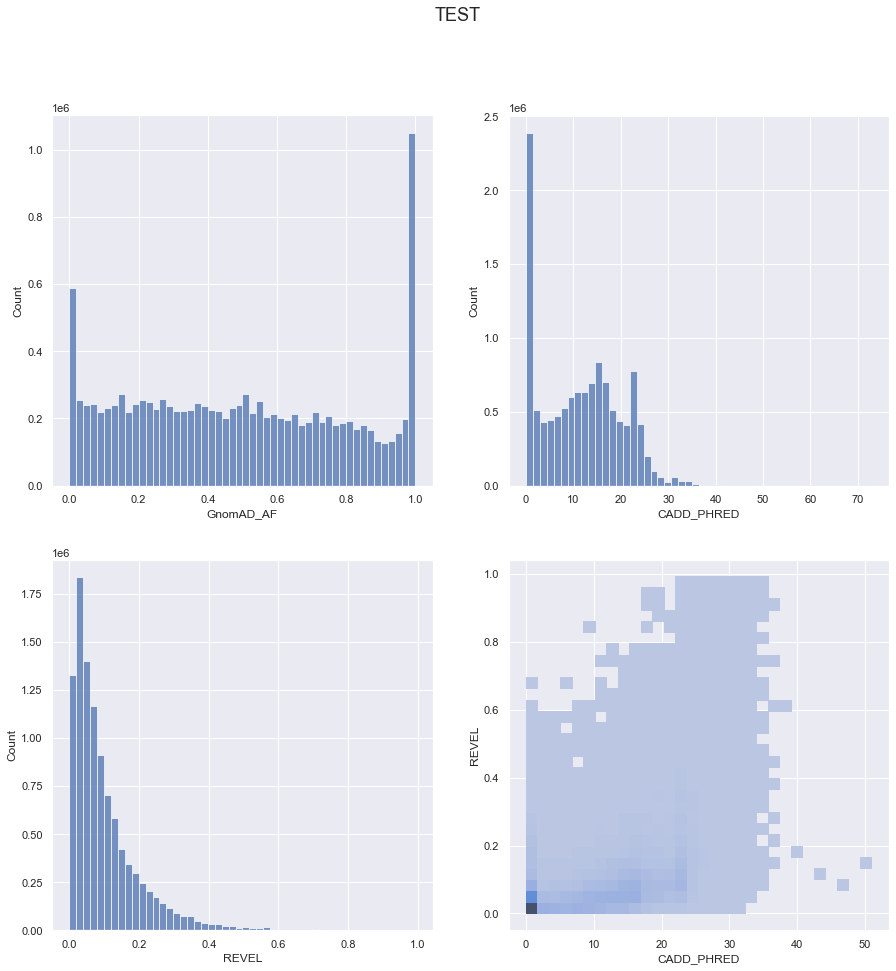

In [5]:
# Values after filtering
plot_summary(dataframe)

## Filtering on user-defined parameters

Using VEP, external variant information was added from GnomAD, CADD, and REVEL. These can be used to filter variants in order to find those which are most likely to be pathogenic. Burden testing relies on these filters as it should (ideally) have deleterious variants only. By altering these parameters, we can see which genes are repeatedly identified as pathogenic - and assume that this indicates a more likely true result than variants which are not consistently high-scoring between iterations.

Some variants will not have annotations for one or more of these databases. In most cases, this indicates a pathogenic score (e.g. a deletion with no REVEL score, a variant not present in GnomAD). As we have already removed synonymous changes, we can assume that missing values are not because there is no change. Therefore when filtering we will count missing values towards a damaging interpretation and retain these variants.

Modify the parameters here and run `Cell/Run All Below` to apply filters

**MAX_GNOMAD:** Sets the maximum GnomAD AF to allow. All variants above this will be removed.

**MIN_CADD:** Sets the minimum CADD score to allow. All variants below this will be removed.

**MIN_REVEL:** Sets the minimum REVEL score to allow. All variants below this will be removed.

In [6]:
# Maximum GnomAD frequency - remove all variants above this
MAX_GNOMAD = 0.05
# Minimum CADD score - remove all variants below this
MIN_CADD = 15
# Minimum REVEL score - premove all variants below this
# DEV: For testing, maybe check with Alison about likely clinical cutoffs?
MIN_REVEL = 0

In [7]:
# Apply filters based on the parameters above
filtered_dataframe = dataframe
filtered_stats = stats

filtered_dataframe = filtered_dataframe[(filtered_dataframe.GnomAD_AF <= MAX_GNOMAD) | (filtered_dataframe.GnomAD_AF.isnull())]
filtered_stats = filtered_stats.append(gather_stats(filtered_dataframe, f"max_GnomAD_{MAX_GNOMAD}"), sort=False)

filtered_dataframe = filtered_dataframe[(filtered_dataframe.CADD_PHRED >= MIN_CADD) | (filtered_dataframe.CADD_PHRED.isnull())]
filtered_stats = filtered_stats.append(gather_stats(filtered_dataframe, f"min_CADD_{MIN_CADD}"), sort=False)

filtered_dataframe = filtered_dataframe[(filtered_dataframe.REVEL >= MIN_REVEL) | (filtered_dataframe.REVEL.isnull())]
filtered_stats = filtered_stats.append(gather_stats(filtered_dataframe, f"min_REVEL_{MIN_REVEL}"), sort=False)

In [8]:
# Work out the number of variants removed at each step, and print a summary
filtered_stats['variants_removed'] = filtered_stats.varcount.shift(1) - filtered_stats.varcount
filtered_stats[["name", "varcount", "variants_removed", "varsperchrom"]]

name  varcount  variants_removed  \
index                                                                    
raw                                    raw  39285541               NaN   
deduplicated                  deduplicated  37359444         1926097.0   
remove_mat_uncertain  remove_mat_uncertain  27487555         9871889.0   
present_in_mothers      present_in_mothers  27481146            6409.0   
no_modifiers                  no_modifiers  27450913           30233.0   
no_low_impact                no_low_impact  13601664        13849249.0   
PCA_passing                    PCA_passing  12035879         1565785.0   
max_GnomAD_0.05            max_GnomAD_0.05   1141503        10894376.0   
min_CADD_15                    min_CADD_15    667446          474057.0   
min_REVEL_0                    min_REVEL_0    667446               0.0   

                                                           varsperchrom  
index                                                                    
raw                   1     3818401
10    1593435
11    2761066
12  ...  
deduplicated          1     3635766
10    1517965
11    2626492
12  ...  
remove_mat_uncertain  1     2691142
10    1119194
11    1961683
12  ...  
present_in_mothers    1     2690572
10    1119153
11    1960915
12  ...  
no_modifiers          1     2690572
10    1117912
11    1955106
12  ...  
no_low_impact         1     1342661
10     541703
11    1046469
12  ...  
PCA_passing           1     1188875
10     480536
11     930081
12  ...  
max_GnomAD_0.05       1     107483
10     43028
11     79132
12     ...  
min_CADD_15           1     64755
10    24646
11    46773
12    4269...  
min_REVEL_0           1     64755
10    24646
11    46773
12    4269...

Variants without GnomAD AF: 84993/667446
Variants without CADD score: 19617/667446
Variants without REVEL score: 137048/667446
Unique variants remaining: 101205
In 17034 genes


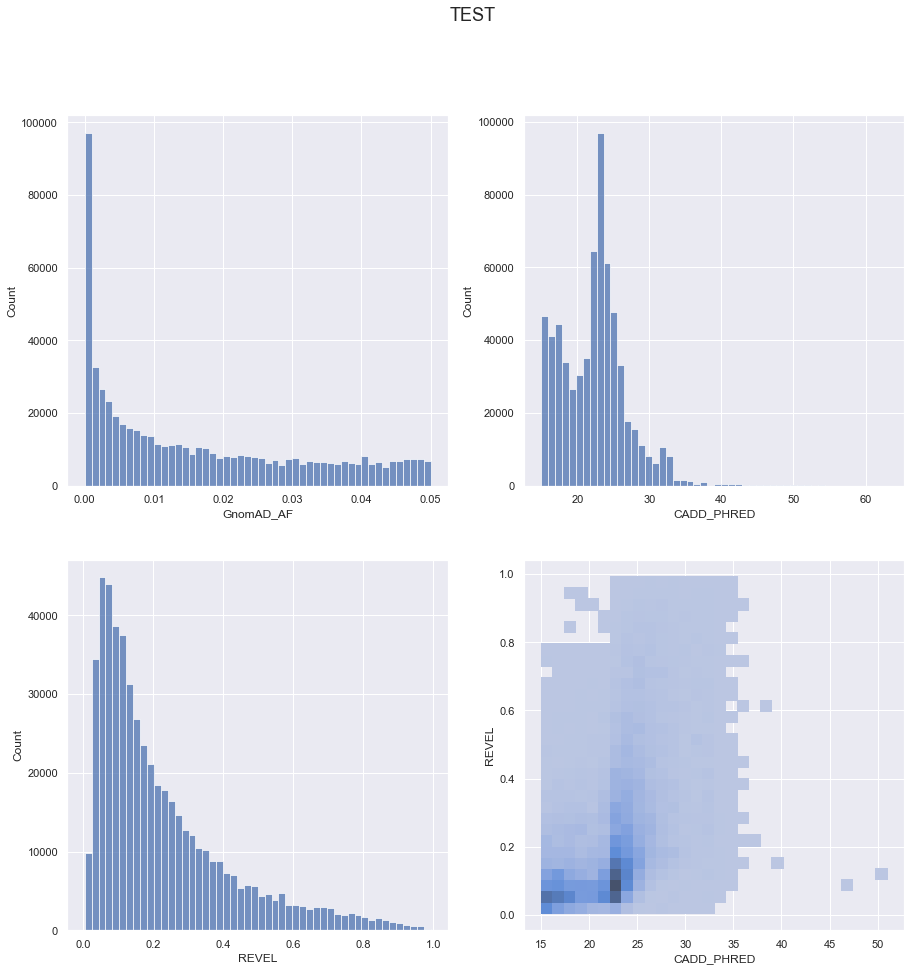

In [9]:
# Values after filtering
plot_summary(filtered_dataframe)

## Add phenotype data
We need to include the pregnancy loss stats so that we can split into cases/controls.

This is added after the filtering as it adds a significant amount of extra data, and results in high memory use.

Then it is saved to a pickle so it can be loaded by the next notebook

In [10]:
# Define the columns we want to use
columns_to_use = [
                  'family_id',
                  'proband_stable_id',
                  'mother_stable_id',
                  'father_stable_id',
                  'mothers_age',	
                  'consanguinity',
                  'birthweight',
                  'assisted_reproduction', 
                  'pregnancy_loss_history'
                 ]

# To get *all* columns (rarely needed) uncomment the line below
#columns_to_use = None

# This is quick enoguh that there's no need (in this case) to use an intermediate pickle
phenotypes = prep_phenotype_dataframe('Data/DDD_Full_Phenotype_Data.csv', columns=columns_to_use)

# Merge the dataframes on proband ID, as this is guaranteed to be unique (I hope!)
# Set the name for the join index column to be the same in both
phenotypes = phenotypes.rename(columns={'mother_stable_id': 'MAT_ID'})
variant_phenotype = pd.merge(filtered_dataframe, phenotypes, on='MAT_ID')

print("Length including duplicates: {} variants".format(variant_phenotype.shape[0]), file=sys.stderr)
# remove duplicate samples (i.e. where a maternal sample is included from multiple probands)
variant_phenotype = variant_phenotype[variant_phenotype.duplicated(['MAT_ID', 'POS']) == False]
print("Length with duplicates removed: {} variants".format(variant_phenotype.shape[0]), file=sys.stderr)

# Unlike other steps, we want to save this to a pickle every time, regardless of whether an
# earlier file is present
variant_phenotype.to_pickle('Processed_data/TEMP.variant_phenotype_merged.pickle')
print(f"{variant_phenotype.shape[0]} variants written to file.", file=sys.stderr)

Length including duplicates: 696404 variants
Length with duplicates removed: 667446 variants
667446 variants written to file.


There is now a dataframe consisting of the list of filertered variants, duplicated for each separate patient in which they were detected. This has been joined to a subset of the information about that patient, which is itself duplicated accross each variant detected in that sample. This is perhaps a little inefficient, but it is simple for quickly and easily checking for a consistent phenotype across variants. If, as shown below, a variant is selected which appears in multiple samples, the details for all those samples will be shown - if, for example, each patient has require assissted reproduction this will be apparent from the data summary. This is not a statistical test, but it may be useful to refer back to *after* the burden test results.

**NOTE:** To change the phenotype fields which are included, the prep_phenotype_dataframe function in functions.py must be edited, then the notebook restarted using `Kernel/Restart & Run All`. This *could* be altered so that the function call takes a list of columns to keep, but that doesn't seem worthwhile.

In [11]:
variant_phenotype[variant_phenotype.GENE == "CLOCK"] #"4:56304529TCTG>T"]

CHROM       POS                ID   GENE    IMPACT  \
734        4  56325365     4:56325365G>C  CLOCK  MODERATE   
3566       4  56325365     4:56325365G>C  CLOCK  MODERATE   
4748       4  56325365     4:56325365G>C  CLOCK  MODERATE   
19820      4  56325365     4:56325365G>C  CLOCK  MODERATE   
25198      4  56325365     4:56325365G>C  CLOCK  MODERATE   
...      ...       ...               ...    ...       ...   
677077     4  56325365     4:56325365G>C  CLOCK  MODERATE   
683284     4  56304529  4:56304529TCTG>T  CLOCK  MODERATE   
683285     4  56325365     4:56325365G>C  CLOCK  MODERATE   
688338     4  56325365     4:56325365G>C  CLOCK  MODERATE   
691483     4  56325365     4:56325365G>C  CLOCK  MODERATE   

                                   HGVSc                          HGVSp  \
734           ENST00000309964.4:c.623C>G  ENSP00000308741.4:p.Ser208Cys   
3566          ENST00000309964.4:c.623C>G  ENSP00000308741.4:p.Ser208Cys   
4748          ENST00000309964.4:c.623C>G  ENSP00000308741.4:p.Ser208Cys   
19820         ENST00000309964.4:c.623C>G  ENSP00000308741.4:p.Ser208Cys   
25198         ENST00000309964.4:c.623C>G  ENSP00000308741.4:p.Ser208Cys   
...                                  ...                            ...   
677077        ENST00000309964.4:c.623C>G  ENSP00000308741.4:p.Ser208Cys   
683284  ENST00000309964.4:c.2278_2280del  ENSP00000308741.4:p.Gln760del   
683285        ENST00000309964.4:c.623C>G  ENSP00000308741.4:p.Ser208Cys   
688338        ENST00000309964.4:c.623C>G  ENSP00000308741.4:p.Ser208Cys   
691483        ENST00000309964.4:c.623C>G  ENSP00000308741.4:p.Ser208Cys   

                     SIFT       Polyphen  CADD_PHRED  REVEL  GnomAD_AF  \
734     deleterious(0.01)  benign(0.375)       24.60   0.18   0.034600   
3566    deleterious(0.01)  benign(0.375)       24.60   0.18   0.034600   
4748    deleterious(0.01)  benign(0.375)       24.60   0.18   0.034600   
19820   deleterious(0.01)  benign(0.375)       24.60   0.18   0.034600   
25198   deleterious(0.01)  benign(0.375)       24.60   0.18   0.034600   
...                   ...            ...         ...    ...        ...   
677077  deleterious(0.01)  benign(0.375)       24.60   0.18   0.034600   
683284                NaN            NaN       17.41    NaN   0.000135   
683285  deleterious(0.01)  benign(0.375)       24.60   0.18   0.034600   
688338  deleterious(0.01)  benign(0.375)       24.60   0.18   0.034600   
691483  deleterious(0.01)  benign(0.375)       24.60   0.18   0.034600   

            MAT_ID  MAT_GT      PAT_ID  PAT_GT      PRO_ID  PRO_GT  \
734     DDDP103328       1  DDDP103329    -1.0  DDDP100131       1   
3566    DDDP105107       1  DDDP105108    -1.0  DDDP100177      -1   
4748    DDDP105396       1  DDDP105397     1.0  DDDP100194       2   
19820   DDDP108392       1  DDDP108393    -1.0  DDDP100518      -1   
25198   DDDP100626       1  DDDP100628    -1.0  DDDP100627      -1   
...            ...     ...         ...     ...         ...     ...   
677077  DDDP138973       1  DDDP138974    -1.0  DDDP138975       1   
683284  DDDP139117       1  DDDP139118    -1.0  DDDP139119      -1   
683285  DDDP139117       1  DDDP139118     1.0  DDDP139119       1   
688338  DDDP139228       1  DDDP139229    -1.0  DDDP139230       1   
691483  DDDP139315       1  DDDP139316    -1.0  DDDP139317      -1   

        cohortsize  patcohort  family_id proband_stable_id father_stable_id  \
734           2476       2476     200040        DDDP100131       DDDP103329   
3566          2476       2476     200081        DDDP100177       DDDP105108   
4748          2476       2476     200093        DDDP100194       DDDP105397   
19820         2476       2476     200301        DDDP100518       DDDP108393   
25198         2476       2476     200361        DDDP100627       DDDP100628   
...            ...        ...        ...               ...              ...   
677077        2476       2476     213318        DDDP138975       DDDP138974   
683284     

In the next notebook, this processed variant/phenotype data will be used to run a collapsing burden test, to identify genes which may be associated with a phenotype (in this case, recurrent miscarraige).